In [12]:
# Kernel -> py311ml
# imports aqui ->
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import shap
from shap import SamplingExplainer


Primeramente vamos a leer el archivo y comprobar las variables, con sus tipos de dato

In [13]:
data = pd.read_csv('src/adult.data', header=None, sep=',\s', na_values=["?"], engine='python')
data.columns = ['age', 'workclass', 'final-weight', 'education', 'education-num', 'marital-status',
                 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                   'hours-per-week', 'native-country', 'income']


def check_df(dataframe, head=5):
    print("------------ Shape ------------")
    print(dataframe.shape)
    print("------------ Types ------------")
    print(dataframe.dtypes)
    
check_df(data)

------------ Shape ------------
(32561, 15)
------------ Types ------------
age                int64
workclass         object
final-weight       int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


Comprobamos que variables contienen valores perdidos 

In [14]:
data.isnull().sum()

age                  0
workclass         1836
final-weight         0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Ahora con ayuda de graficas, visualizamos la distribucion de las variables anteriores


Index(['age', 'workclass', 'final-weight', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


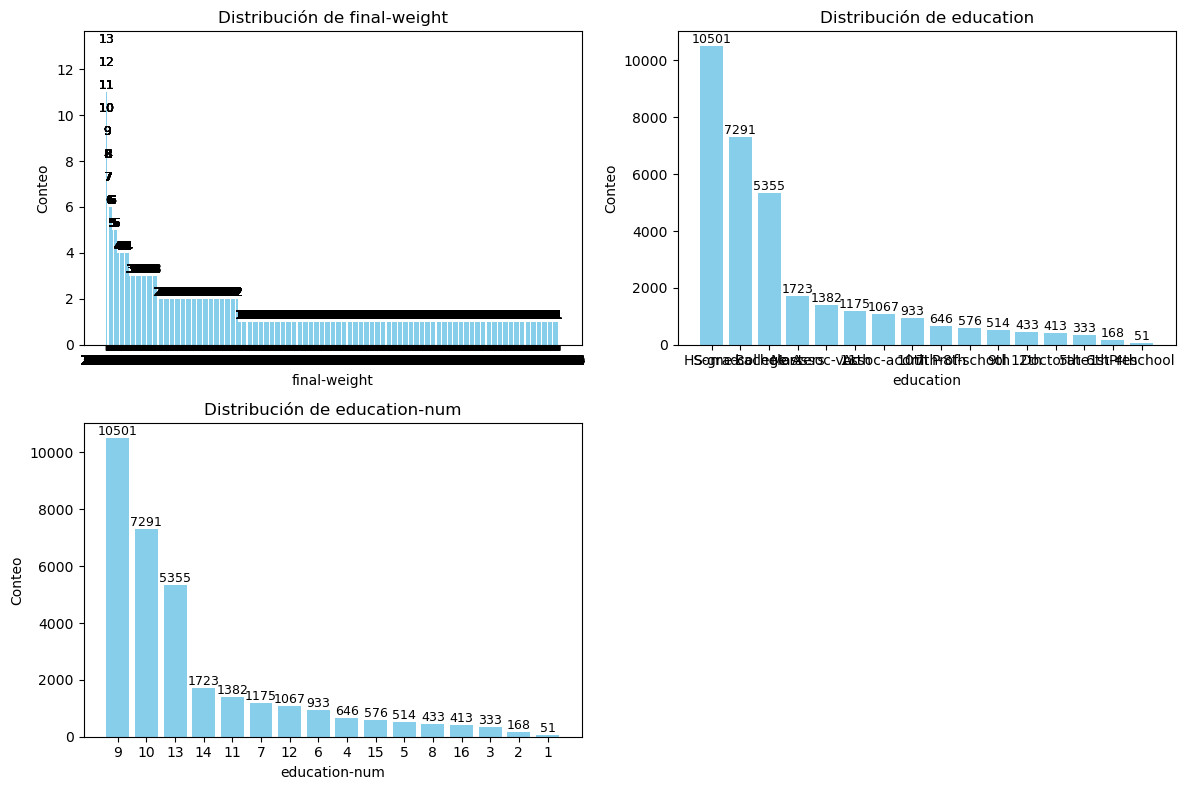

In [15]:

def check_col_plt(df, columns):
    num_plots = len(columns)
    # Definimos el número de filas y columnas del grid. En este ejemplo usamos 2x2.
    rows, cols = 2, 2

    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()  # Aplanamos la matriz de ejes para iterar fácilmente

    for i, col in enumerate(columns):
        ax = axes[i]
        # Obtenemos la cuenta de cada valor único en la columna
        count_data = df[col].value_counts().reset_index()
        count_data.columns = [col, 'count']

        # Creamos el gráfico de barras
        bars = ax.bar(count_data[col].astype(str), count_data['count'], color='skyblue')
        ax.set_title(f"Distribución de {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Conteo")

        # Añadimos las etiquetas de conteo encima de cada barra
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}',
                    ha='center', va='bottom', fontsize=9)

    # Eliminamos los ejes sobrantes si hay menos plots que subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
print(data.columns)
# Ejemplo de uso
ncolumns = ["final-weight", "education", "education-num"]
check_col_plt(data, ncolumns)


In [16]:
# #Valores periddos
# columnas_con_nulos = data.columns[data.isnull().any()].tolist()
# print(columnas_con_nulos)

# def rellenarModa(data, columna):
#     dataCopiada = data.copy()
#     moda = dataCopiada.loc[:, columna].mode()[0]
#     dataCopiada[columna] = dataCopiada[columna].fillna(moda)
#     return dataCopiada

# X = rellenarModa(data, columnas_con_nulos[0])
# X = rellenarModa(X, columnas_con_nulos[2])
# print(X.isnull().sum())

OUTLIERS CON MEDIANA



In [17]:

class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe(percentiles=[0.25, 0.75])
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calcula el IQR de cada variable
        # IQRs = Xaux.quantile(0.75) - Xaux.quantile(0.25)
        IQRs = self.stats.loc["75%", :] - self.stats.loc["25%", :]
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc["25%", :] - self.k * IQRs
        limiteSup = self.stats.loc["75%", :] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = Xaux < limiteInf
        mayores = Xaux > limiteSup
        valores = np.logical_or(menores, mayores)
        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        out_total = 0
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = valores[c]
            # Si hay outliers
            if indices.any():
                # Los sustituimos por la mediana
                Xaux.loc[indices, c] = Xaux[c].median()
                out_total += len(indices)
        # Se devuelve el DataFrame modificado
        # print("Total de outliers: ", out_total)
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}
    
class OutlierDetecion_treatment_MeanStd(TransformerMixin):
    # Constructor de la clase
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.mean = X.mean()
        self.std = X.std()
        self.median = X.median()
        return self
    
    def transform(self, X):
        Xaux = X.copy()
        out_total = 0
        for c in X.columns:
            # Se calculan los límites inferiores y superiores
            limiteInf = self.mean[c] - self.k * self.std[c]
            limiteSup = self.mean[c] + self.k * self.std[c]
            # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)
            menores = Xaux[c] < limiteInf
            mayores = Xaux[c] > limiteSup
            valores = np.logical_or(menores, mayores)
            # Si hay outliers
            if valores.any():
                # Los sustituimos por la mediana
                Xaux.loc[valores, c] = self.median[c]
                out_total += len(valores)
        # print("Total de outliers: " , out_total)
        return Xaux
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def get_params(self, deep=True):
        return {"k": self.k}

OUTLIERS CON MEDIA

In [18]:

class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe(percentiles=[0.25, 0.75])
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calcula el IQR de cada variable
        # IQRs = Xaux.quantile(0.75) - Xaux.quantile(0.25)
        IQRs = self.stats.loc["75%", :] - self.stats.loc["25%", :]
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc["25%", :] - self.k * IQRs
        limiteSup = self.stats.loc["75%", :] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = Xaux < limiteInf
        mayores = Xaux > limiteSup
        valores = np.logical_or(menores, mayores)
        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        out_total = 0
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = valores[c]
            # Si hay outliers
            if indices.any():
                # Los sustituimos por la mediana
                Xaux.loc[indices, c] = Xaux[c].mean()
                out_total += len(indices)
        # Se devuelve el DataFrame modificado
        # print("Total de outliers: ", out_total)
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}
    
class OutlierDetecion_treatment_MeanStd(TransformerMixin):
    # Constructor de la clase
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.mean = X.mean()
        self.std = X.std()
        self.median = X.median()
        return self
    
    def transform(self, X):
        Xaux = X.copy()
        out_total = 0
        for c in X.columns:
            # Se calculan los límites inferiores y superiores
            limiteInf = self.mean[c] - self.k * self.std[c]
            limiteSup = self.mean[c] + self.k * self.std[c]
            # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)
            menores = Xaux[c] < limiteInf
            mayores = Xaux[c] > limiteSup
            valores = np.logical_or(menores, mayores)
            # Si hay outliers
            if valores.any():
                # Los sustituimos por la mediana
                Xaux.loc[valores, c] = self.mean[c]
                out_total += len(valores)
        # print("Total de outliers: " , out_total)
        return Xaux
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def get_params(self, deep=True):
        return {"k": self.k}

OUTLIERS CON LIMITE SUPERIOR - INFERIOR

In [19]:
class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe(percentiles=[0.25, 0.75])
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        X = pd.DataFrame(X)
        Xaux = X.copy()

        # Estadísticos guardados en fit
        IQRs      = self.stats.loc["75%", :] - self.stats.loc["25%", :]
        limiteInf = self.stats.loc["25%", :] - self.k * IQRs
        limiteSup = self.stats.loc["75%", :] + self.k * IQRs

        # Para cada columna, winsorizamos
        for c in self.columns:
            mask_low  = Xaux[c] < limiteInf[c]
            mask_high = Xaux[c] > limiteSup[c]
            if mask_low.any():
                Xaux.loc[mask_low,  c] = limiteInf[c]
            if mask_high.any():
                Xaux.loc[mask_high, c] = limiteSup[c]

        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}
    
    from sklearn.base import TransformerMixin

class OutlierDetecion_treatment_MeanStd(TransformerMixin):
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # Calculamos y guardamos media y desviación por columna
        self.mean_ = X.mean()
        self.std_  = X.std()
        return self
    
    def transform(self, X):
        Xaux = pd.DataFrame(X).copy()
        # Cálculo de límites por columna
        limiteInf = self.mean_ - self.k * self.std_
        limiteSup = self.mean_ + self.k * self.std_
        
        # Winsorización
        for c in Xaux.columns:
            # Máscaras
            mask_low  = Xaux[c] < limiteInf[c]
            mask_high = Xaux[c] > limiteSup[c]
            # Sustitución por límites
            if mask_low.any():
                Xaux.loc[mask_low,  c] = limiteInf[c]
            if mask_high.any():
                Xaux.loc[mask_high, c] = limiteSup[c]
        
        return Xaux
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def get_params(self, deep=True):
        return {"k": self.k}


Version para usar con column transformer y meter este paso en la pipeline


In [20]:
def rellenarModa(data):
    dataCopiada = data.copy()
    # Si 'columnas' no es una lista, se convierte en una lista
    columnas = dataCopiada.columns[dataCopiada.isnull().any()].tolist()
    for columna in columnas:
        if (columna != "occupation"):
        # Calcula la moda de la columna y rellena los valores nulos
            moda = dataCopiada[columna].mode()[0]
            dataCopiada[columna] = dataCopiada[columna].fillna(moda)
    return dataCopiada
# Ahora lo envolvemos en un FunctionTransformer
imputador_modas = FunctionTransformer(rellenarModa, validate=False)

In [60]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

def rellenarKnn(data):
    #Columna a imputar
    columna = "occupation"

    # 2. Crear una copia del DataFrame
    dataCopiada = data.copy()

    # 3. Guardar las filas con y sin valores faltantes
    #df_completo = df_copy[df_copy[columna].notna()]
    #df_faltante = df_copy[df_copy[columna].isna()]

    # 4. Codificar la columna objetivo con LabelEncoder
    le_obj = LabelEncoder()
    dataCopiada[columna] = dataCopiada[columna].astype(str)
    dataCopiada[columna] = le_obj.fit_transform(dataCopiada[columna])

    # 5. Codificar otras columnas categóricas (si hay), necesarias para el imputador
    label_encoders = {}
    for col in dataCopiada.columns:
        if dataCopiada[col].dtype == 'object' and col != columna:
            le = LabelEncoder()
            dataCopiada[col] = dataCopiada[col].astype(str)
            dataCopiada[col] = le.fit_transform(dataCopiada[col])
            label_encoders[col] = le

# 6. Crear subconjunto de columnas para imputación
# (puede ser todo menos la columna objetivo o solo algunas relevantes)
    columnasPred = dataCopiada.columns[dataCopiada.columns != columna]

    # 7. Juntar columna objetivo + predictoras
    df_model = dataCopiada[[columna] + list(columnasPred)]

    # 8. Aplicar KNNImputer solo a esta matriz
    imputer = KNNImputer(n_neighbors=5)
    dataImputada = pd.DataFrame(imputer.fit_transform(df_model), columns=df_model.columns)

    # 9. Redondear y reconvertir la columna objetivo
    dataImputada[columna] = dataImputada[columna].astype(int)
    dataImputada[columna] = le_obj.inverse_transform(dataImputada[columna])

    # 10. Insertar la columna imputada en el DataFrame original
    dataFinal = data.copy()
    dataFinal[columna] = dataImputada[columna]
    print(dataFinal.isnull().sum())
    return dataFinal

imputador_knn = FunctionTransformer(rellenarKnn, validate=False)

Pipeline

In [61]:
def transformar_income(X): 
    """Transforma la columna 'income' en una variable binaria."""

    X = X.copy()
    X['income'] = X['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    return X

def separar_x_y(data):
    X = data.drop('income', axis=1)
    y = data['income']
    return X, y

def separar_x_y_col(data, col):
    X = data.drop(col, axis=1)
    y = data[col]
    return X, y

def transformar_categoricas_a_binarias(X): 

    X = X.copy()
    variables_categoricas_binarias = X.select_dtypes(include=['object']).columns
    dummies = pd.get_dummies(X, columns=variables_categoricas_binarias)
    if hasattr(transformar_categoricas_a_binarias, 'dummy_columns'):
        dummies = dummies.reindex(columns=transformar_categoricas_a_binarias.dummy_columns, fill_value=0)
    else:
        transformar_categoricas_a_binarias.dummy_columns = dummies.columns
    return dummies

def knnImp(X, y):
    y = y.copy()
    indicesNulos = np.where(y == -1)[0] 
    indicesNoNulos = np.where(y != -1)[0] 
    X_train = X.iloc[indicesNoNulos]
    X_test = X.iloc[indicesNulos]
    y_train = y[indicesNoNulos]

    
    knn = KNeighborsClassifier(n_neighbors= 3)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    y[indicesNulos] = pred
    return y

binary_transformer = FunctionTransformer(transformar_categoricas_a_binarias)

data_binary_income = transformar_income(data)
X, y = separar_x_y(data_binary_income)
# X, occupation = separar_x_y_col(X, "occupation")
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# X_transformed = binary_transformer.transform(X)
# occupationNombre = occupation.copy()
# valoresOccupation = occupationNombre.dropna()
# colConNulos = pd.Categorical(occupation, ordered= True).codes #Paso la variable a ordinal 

# occupation_ord = knnImp(X_transformed, colConNulos) #Imputo los valores
# occupation_series = pd.Series(occupation_ord)
# occupation_mapeados = occupation_series.map(lambda x: occupationNombre[x])

# occupationOHE = pd.get_dummies(occupation_mapeados)
# X_transformed = pd.concat([X_transformed, occupationOHE], axis = 1) #Todas las columnas sin nulos y en OHE


numeric_transformer = Pipeline(steps=[
    # ('outlier_detection', OutlierDetecion_treatment_MeanStd(k=5)),
    ('outlier_detection', OutlierDetecion_treatment_IQR(k=5)),
    # ('scaler', RobustScaler())
    # ('scaler', StandardScaler()), 
    # ('scaler', MinMaxScaler()) Descartado despues de las pruebas
])

preprocessorBasic = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), 
        ('cat', OneHotEncoder(), categorical_features),
    ])

# Definimos el pipeline con el transformador
pipeline = Pipeline([
    ('valores_perdidos', imputador_modas),
    ('ocupation_perdidos', imputador_knn),
    ('preprocesador', preprocessorBasic),
    ('classifier', KNeighborsClassifier())
])

data_binary_income = transformar_income(data)
X, y = separar_x_y(data_binary_income)
pipeline.fit(X, y)


age               0
workclass         0
final-weight      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64


Pipeline(steps=[('valores_perdidos',
                 FunctionTransformer(func=<function rellenarModa at 0x000002AC557DC180>)),
                ('ocupation_perdidos',
                 FunctionTransformer(func=<function rellenarKnn at 0x000002B794199EE0>)),
                ('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('outlier_detection',
                                                                   <__main__.OutlierDetecion_treatment_IQR object at 0x000002B794195250>)]),
                                                  Index(['age', 'final-weight', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('classifier', KNeighborsClassifier())])

In [51]:
print(X.columns)

Index(['age', 'workclass', 'final-weight', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')


In [52]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

for c in X_transformed.columns:
    if c in X:  # No es OHE
        print("")
    else:
        contingency_table = pd.crosstab(X_transformed[c], y)  # Tabla de frecuencias

        chi2, _, _, _ = chi2_contingency(contingency_table)  
        n = contingency_table.sum().sum()  
        r, k = contingency_table.shape  

        if min(r, k) - 1 == 0: #Por si hay una division por cero
            print("Fallo en ", c, " división por 0")
            continue
        q = min(r, k)
        v = np.sqrt(chi2 / (n * ( q - 1)))  
        if (v > 0.1):
            print("La correlacion para ", c, "es de ", v)


NameError: name 'X_transformed' is not defined

Una vez pasadas todas las variables a numericas, podemos ver la matriz de corelacion 

In [ ]:
# X_transformed = binary_transformer.transform(X)
# X_transformed = pd.concat([X_transformed, y], axis=1)
# corr_matrix = X_transformed.corr()
# filtered_corr = corr_matrix.where(corr_matrix != 1)

# plt.figure(figsize=(60,60))
# sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt='.2f')
# plt.show()

Se observan varias correlaciones, algunas obvias como marital-status_Married-civ-spouse con relationship_husband y otras que vamos a analizar. Primero vamos a ver las mas influyentes en el propio resultado
 

In [ ]:
correlations = X_transformed.corr()['income'].sort_values(ascending=False)
correlations = abs(correlations).sort_values(ascending=False)
correlations = correlations.drop('relationship_Husband') 
correlations = correlations.drop('sex_Male')
correlations = correlations.drop('sex_Female')


print("Most influential factors:\n", correlations[:6])

Most influential factors:
 income                               1.000000
marital-status_Married-civ-spouse    0.444696
education-num                        0.335154
marital-status_Never-married         0.318440
age                                  0.234037
hours-per-week                       0.229689
Name: income, dtype: float64


Probamos el rendimiento de nuetro modelo con la metrica seleccionada 

In [ ]:
data_binary_income = transformar_income(data)
X, y = separar_x_y(data_binary_income)
pipeline.fit(X, y)


Pipeline(steps=[('valores_perdidos',
                 FunctionTransformer(func=<function rellenarModa at 0x000001E89ED25620>)),
                ('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('outlier_detection',
                                                                   <__main__.OutlierDetecion_treatment_IQR object at 0x000001E89CE944D0>)]),
                                                  Index(['age', 'final-weight', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('classifier', KNeighborsClassifier())])

In [ ]:
predicciones = pipeline.predict(X)
print("Accuracy:", accuracy_score(y, predicciones))
print("Confusion Matrix:\n", confusion_matrix(y, predicciones))
print("AUC:", roc_auc_score(y, predicciones)) 

Accuracy: 0.8075304812505758
Confusion Matrix:
 [[23198  1522]
 [ 4745  3096]]
AUC: 0.6666390083409379


Probamos el rendimiento de nuestro modelo con el test.data que previamente esta dividio por|1x3 Cross validator

In [ ]:
#Quitamos el punto final
def transformar_income_test(X): 
    X = X.copy()
    X['income'] = X['income'].str.strip().str.rstrip('.')
    X['income'] = X['income'].map({'<=50K': 0, '>50K': 1})
    return X

data_test = pd.read_csv('src/adult.test', header=None, skiprows=1, sep=',\s', na_values=["?"], engine='python')
data_test.columns = ['age', 'workclass', 'final-weight', 'education', 'education-num', 'marital-status',
                     'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                     'hours-per-week', 'native-country', 'income']

data_test = transformar_income_test(data_test)
X_test, y_test = separar_x_y(data_test)
# X_test_transformed = binary_transformer.transform(X_test)


#Predecimos los valores con el conjunto del test
predicciones_test = pipeline.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, predicciones_test))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, predicciones_test))
print("Test AUC:", roc_auc_score(y_test, predicciones_test))



Test Accuracy: 0.7296849087893864
Test Confusion Matrix:
 [[11074  1361]
 [ 3040   806]]
Test AUC: 0.5500596236153427


SHAP

In [ ]:
import shap
import numpy as np
from sklearn.utils import resample

# ---------- 1. Background resumido ----------
# • Opción rápida: muestrear aleatoriamente
background = shap.sample(X, 100, random_state=42)
# • Opción algo mejor: k‑means
# background = shap.kmeans(X, 100, random_state=42)

# ---------- 2. Muestra de evaluación ----------
X_eval = shap.sample(X, 300, random_state=42)

# ---------- 3. Explainer (Kernel o Sampling) ----------
# 3a) KernelExplainer con número limitado de coaliciones
explainer = shap.KernelExplainer(
    lambda data: pipeline.predict_proba(data)[:, 1],   # probab. de la clase positiva
    background
)

# Puedes limitar aún más con nsamples:
shap_values = explainer.shap_values(X_eval, nsamples=100)  # nº de coaliciones máx.

# 3b) (alternativa) SamplingExplainer ─más rápido, algo más ruidoso
# explainer = shap.SamplingExplainer(lambda data: pipeline.predict_proba(data)[:, 1],
#                                    background)
# shap_values = explainer.shap_values(X_eval, nsamples=200)  

# ---------- 4. Gráfico ----------
shap.summary_plot(shap_values, X_eval)


Provided model function fails when applied to the provided data set.


AttributeError: 'numpy.ndarray' object has no attribute 'columns'